# NLP & representation learning: Neural Embeddings, Text Classification


To use statistical classifiers with text, it is first necessary to vectorize the text. In the first practical session we explored the **Bag of Word (BoW)** model. 

Modern **state of the art** methods uses  embeddings to vectorize the text before classification in order to avoid feature engineering.

## [Dataset](https://thome.isir.upmc.fr/classes/RITAL/json_pol)


## "Modern" NLP pipeline

By opposition to the **bag of word** model, in the modern NLP pipeline everything is **embeddings**. Instead of encoding a text as a **sparse vector** of length $D$ (size of feature dictionnary) the goal is to encode the text in a meaningful dense vector of a small size $|e| <<< |D|$. 


The raw classification pipeline is then the following:

```
raw text ---|embedding table|-->  vectors --|Neural Net|--> class 
```


### Using a  language model:

How to tokenize the text and extract a feature dictionnary is still a manual task. To directly have meaningful embeddings, it is common to use a pre-trained language model such as `word2vec` which we explore in this practical.

In this setting, the pipeline becomes the following:
```
      
raw text ---|(pre-trained) Language Model|--> vectors --|classifier (or fine-tuning)|--> class 
```


- #### Classic word embeddings

 - [Word2Vec](https://arxiv.org/abs/1301.3781)
 - [Glove](https://nlp.stanford.edu/projects/glove/)


- #### bleeding edge language models techniques (see next)

 - [UMLFIT](https://arxiv.org/abs/1801.06146)
 - [ELMO](https://arxiv.org/abs/1802.05365)
 - [GPT](https://blog.openai.com/language-unsupervised/)
 - [BERT](https://arxiv.org/abs/1810.04805)






### Goal of this session:

1. Train word embeddings on training dataset
2. Tinker with the learnt embeddings and see learnt relations
3. Tinker with pre-trained embeddings.
4. Use those embeddings for classification
5. Compare different embedding models
6. Pytorch first look: learn to generate text.

## STEP 0: Loading data 

In [1]:
import warnings  
warnings.filterwarnings(action='ignore',category=UserWarning,module='gensim')  
warnings.filterwarnings(action='ignore',category=FutureWarning,module='gensim') 
import gensim
import logging
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import json
from collections import Counter

# Loading json
with open("json_pol",encoding="utf-8") as f:
    data = f.readlines()
    json_data = json.loads(data[0])
    train = json_data["train"]
    test = json_data["test"]
    

# Quick Check
counter_train = Counter((x[1] for x in train))
counter_test = Counter((x[1] for x in test))
print("Number of train reviews : ", len(train))
print("----> # of positive : ", counter_train[1])
print("----> # of negative : ", counter_train[0])
print("")
print(train[0])
print("")
print("Number of test reviews : ",len(test))
print("----> # of positive : ", counter_test[1])
print("----> # of negative : ", counter_test[0])

print("")
print(test[0])
print("")

Number of train reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

["The undoubted highlight of this movie is Peter O'Toole's performance. In turn wildly comical and terribly terribly tragic. Does anybody do it better than O'Toole? I don't think so. What a great face that man has!<br /><br />The story is an odd one and quite disturbing and emotionally intense in parts (especially toward the end) but it is also oddly touching and does succeed on many levels. However, I felt the film basically revolved around Peter O'Toole's luminous performance and I'm sure I wouldn't have enjoyed it even half as much if he hadn't been in it.", 1]

Number of test reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

['Although credit should have been given to Dr. Seuess for stealing the story-line of "Horton Hatches The Egg", this was a fine film. It touched both the emotions and the intellect. Due especially to the incredible performance of seven year old 

## Word2Vec: Quick Recap

**[Word2Vec](https://arxiv.org/abs/1301.3781) is composed of two distinct language models (CBOW and SG), optimized to quickly learn word vectors**


given a random text: `i'm taking the dog out for a walk`



### (a) Continuous Bag of Word (CBOW)
    -  predicts a word given a context
    
maximizing `p(dog | i'm taking the ___ out for a walk)`
    
### (b) Skip-Gram (SG)               
    -  predicts a context given a word
    
 maximizing `p(i'm taking the out for a walk | dog)`



   

## STEP 1: train a language model (word2vec)

Gensim has one of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) fastest implementation.


### Train:

In [5]:
# if gensim not installed yet
# ! pip install gensim

In [4]:

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

text = [t.split() for t,p in train]

# the following configuration is the default configuration
w2v = gensim.models.word2vec.Word2Vec(sentences=text,
                                vector_size=100, window=5,               ### here we train a cbow model 
                                min_count=5,                      
                                sample=0.001, workers=3,
                                sg=1, hs=0, negative=5,        ### set sg to 1 to train a sg model
                                cbow_mean=1, epochs=5)

In [3]:
# Worth it to save the previous embedding
# w2v.save("W2v-movies.dat")
# You will be able to reload them:
w2v = gensim.models.Word2Vec.load("W2v-movies.dat")
# and you can continue the learning process if needed

## STEP 2: Test learnt embeddings

The word embedding space directly encodes similarities between words: the vector coding for the word "great" will be closer to the vector coding for "good" than to the one coding for "bad". Generally, [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is the distance used when considering distance between vectors.

KeyedVectors have a built in [similarity](https://radimrehurek.com/gensim/models /keyedvectors.html#gensim.models.keyedvectors.BaseKeyedVectors.similarity) method to compute the cosine similarity between words

In [4]:
# is great really closer to good than to bad ?
print("great and good:",w2v.wv.similarity("great","good"))
print("great and bad:",w2v.wv.similarity("great","bad"))

great and good: 0.7798576
great and bad: 0.45752424


Since cosine distance encodes similarity, neighboring words are supposed to be similar. The [most_similar](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.BaseKeyedVectors.most_similar) method returns the `topn` words given a query.

In [5]:
# The query can be as simple as a word, such as "movie"

# Try changing the word
# w2v.wv.most_similar("movie",topn=5) # 5 most similar words
# w2v.wv.most_similar("awesome",topn=5)
w2v.wv.most_similar("Although",topn=5)

[('Though', 0.863980770111084),
 ('While', 0.8636260032653809),
 ('However,', 0.8314102292060852),
 ('However', 0.803390383720398),
 ('Still,', 0.795049786567688)]

But it can be a more complicated query
Word embedding spaces tend to encode much more.

The most famous exemple is: `vec(king) - vec(man) + vec(woman) => vec(queen)`

In [6]:
# What is awesome - good + bad ?
w2v.wv.most_similar(positive=["awesome","bad"],negative=["good"],topn=3)  

w2v.wv.most_similar(positive=["actor","woman"],negative=["man"],topn=3) # do the famous exemple works for actor ?
w2v.wv.most_similar(positive=["movie","film"],negative=["movies"],topn=3)

# Try other things like plurals for exemple.

[('"film"', 0.7406459450721741),
 ('it', 0.6212536692619324),
 ('movie,', 0.6170195937156677)]

To test learnt "synctactic" and "semantic" similarities, Mikolov et al. introduced a special dataset containing a wide variety of three way similarities.

In [7]:
out = w2v.wv.evaluate_word_analogies("questions-words.txt",case_insensitive=True)  #original semantic syntactic dataset.

**When training the w2v models on the review dataset, since it hasn't been learnt with a lot of data, it does not perform very well.**


## STEP 3: Loading a pre-trained model

In Gensim, embeddings are loaded and can be used via the ["KeyedVectors"](https://radimrehurek.com/gensim/models/keyedvectors.html) class

> Since trained word vectors are independent from the way they were trained (Word2Vec, FastText, WordRank, VarEmbed etc), they can be represented by a standalone structure, as implemented in this module.

>The structure is called “KeyedVectors” and is essentially a mapping between entities and vectors. Each entity is identified by its string id, so this is a mapping between {str => 1D numpy array}.

>The entity typically corresponds to a word (so the mapping maps words to 1D vectors), but for some models, they key can also correspond to a document, a graph node etc. To generalize over different use-cases, this module calls the keys entities. Each entity is always represented by its string id, no matter whether the entity is a word, a document or a graph node.

In [7]:
#from gensim.test.utils import get_tmpfile
import gensim.downloader as api
from gensim.models import KeyedVectors
bload = True
fname = "word2vec-google-news-300"
sdir = "word2vec-google-news-300/"

if(bload==True):
    wv_pre_trained = KeyedVectors.load(sdir+fname+".dat")
else:    
    wv_pre_trained = api.load(fname)
    wv_pre_trained.save(sdir+fname+".dat")

In [ ]:
out = wv_pre_trained.evaluate_word_analogies("questions-words.txt",case_insensitive=True)  #original semantic syntactic dataset.

**Perform the "synctactic" and "semantic" evaluations again. Conclude on the pre-trained embeddings.**

## STEP 4:  sentiment classification

In the previous practical session, we used a bag of word approach to transform text into vectors.
Here, we propose to try to use word vectors (previously learnt or loaded).


### <font color='green'> Since we have only word vectors and that sentences are made of multiple words, we need to aggregate them. </font>


### (1) Vectorize reviews using word vectors:

Word aggregation can be done in different ways:

- Sum
- Average
- Min/feature
- Max/feature

#### a few pointers:

- `w2v.wv.vocab` is a `set()` of the vocabulary (all existing words in your model)
- `np.minimum(a,b) and np.maximum(a,b)` respectively return element-wise min/max 

In [4]:
import numpy as np
# We first need to vectorize text:
# First we propose to a sum of them


def vectorize(text,model,mean=False,minFeat=False,maxFeat=False):
    '''
    This function should vectorize one review

    input: str
    output: np.array(float)
    '''
    vocabulary = model.wv.key_to_index.keys()
    
    weights = [model.wv.get_vector(word) for word in text.split(" ") if word in vocabulary]
    
    if mean:
        return np.mean(weights,axis=0)
    if minFeat:
        return np.min(weights,axis=0)
    if maxFeat:
        return np.max(weights,axis=0)
    
    return np.sum(weights,axis=0)
    
classes = [pol for text,pol in train]
X = [vectorize(text,w2v,mean=True) for text,pol in train]
X_test = [vectorize(text,w2v,mean=True) for text,pol in test]
true = [pol for text,pol in test]

#let's see what a review vector looks like.
print(X[0])

[-0.00363242  0.12418909  0.01566555  0.04415126 -0.00508231 -0.27246916
  0.19513953  0.3751213  -0.34567207 -0.26771784 -0.01835521 -0.3196532
  0.0329181   0.20886584  0.12046224 -0.11845102  0.10777609 -0.12048113
 -0.03360869 -0.4484004   0.15153204  0.07441775  0.16307026 -0.24295951
  0.11419878 -0.04394715 -0.14721656  0.03436415 -0.1520337   0.21216539
  0.29205474 -0.11554233  0.11436694 -0.23363574 -0.04453686  0.1854144
 -0.02902844  0.07646015 -0.16564287 -0.16695191  0.2006799  -0.10824912
 -0.1035899   0.0131361   0.13083714 -0.01996426 -0.21404062 -0.08637805
  0.25914088  0.23668924  0.107595   -0.2512329  -0.01381236  0.04372877
  0.01957311  0.11562493  0.07492033  0.11477908 -0.17324945  0.08195102
 -0.10190435 -0.02096242  0.2491143   0.11524353 -0.11877654  0.21503681
  0.01073598  0.1223154  -0.19175617  0.15435275  0.06035062  0.12463818
  0.13395752  0.03213201  0.1438389  -0.07004435  0.18406384 -0.05245426
 -0.07198591  0.00593548 -0.24222563 -0.09089641 -0.1

In [9]:
# t-SNE from the U matrix computed by LSA
tsne = TSNE(n_components=2, init='pca',n_iter=250, verbose=0)
tsne_mat = tsne.fit_transform(X)

/home/amine/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/amine/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


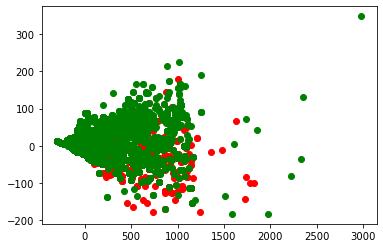

In [24]:
cla1 = np.where(np.array(classes) == 0)
cla2 = np.where(np.array(classes) == 1)
plt.scatter(tsne_mat[cla1,0],tsne_mat[cla1,1],color='Red')
plt.scatter(tsne_mat[cla2,0],tsne_mat[cla2,1],color='Green')

### (2) Train a classifier 
as in the previous practical session, train a logistic regression to do sentiment classification with word vectors



In [5]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X,classes, test_size=0.2, random_state=0) 

lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1)
lr_clf.fit(X_train,y_train)
pred_lr = lr_clf.predict(X_test)
print(f"Logistic Regression accuracy: {accuracy_score(y_test, pred_lr)}")

Logistic Regression accuracy: 0.8204


/home/amine/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


performance should be worst than with bag of word (~80%). Sum/Mean aggregation does not work well on long reviews (especially with many frequent words). This adds a lot of noise.

## **Todo** :  Try answering the following questions:

- Which word2vec model works best: skip-gram or cbow
- Do pretrained vectors work best than those learnt on the train dataset ?



**(Bonus)** To have a better accuracy, we could try two things:
- Better aggregation methods (weight by tf-idf ?)
- Another word vectorizing method such as [fasttext](https://radimrehurek.com/gensim/models/fasttext.html)
- A document vectorizing method such as [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html)

### Agregation avec ponderation de tf-idf

In [6]:
data = np.array(train)
# corpus = " ".join(data[:1000,0])
corpus = data[:,0]

In [44]:
corpus[0]

"The undoubted highlight of this movie is Peter O'Toole's performance. In turn wildly comical and terribly terribly tragic. Does anybody do it better than O'Toole? I don't think so. What a great face that man has!<br /><br />The story is an odd one and quite disturbing and emotionally intense in parts (especially toward the end) but it is also oddly touching and does succeed on many levels. However, I felt the film basically revolved around Peter O'Toole's luminous performance and I'm sure I wouldn't have enjoyed it even half as much if he hadn't been in it."

In [11]:
vectorizer = TfidfVectorizer(use_idf= True, smooth_idf=True, sublinear_tf=True)
bow_tfidf = vectorizer.fit_transform(corpus)

In [51]:
a = bow_tfidf.getrow(0).toarray()
# bow_tfidf.get
# vovalues = np.array(list(w2v.wv.key_to_index.keys()))
# words = np.array(vectorizer.get_feature_names())
# same = np.intersect1d(words,vovalues)
# # w00 = same[1020]
# # w2v.wv.get_vector(w)
# new_w2v = []
# doc0 = corpus[0]
# for word in doc0.split(" "):
#     if word in same:
#         print(bow_tfidf[0])

def get_tfidf_word(word,num_document,vectorizer,bow_tfidf):
    words = np.array(vectorizer.get_feature_names())
    indice = int(np.where(words == word)[0])
    tfidf_docu = bow_tfidf.getrow(num_document).toarray()
    # tfidf_docu est un vecteur colonne 
    return tfidf_docu[:,indice][0]

get_tfidf_word("undoubted",0,vectorizer,bow_tfidf)

0.23646594157738154

In [61]:
train[0][0]

"The undoubted highlight of this movie is Peter O'Toole's performance. In turn wildly comical and terribly terribly tragic. Does anybody do it better than O'Toole? I don't think so. What a great face that man has!<br /><br />The story is an odd one and quite disturbing and emotionally intense in parts (especially toward the end) but it is also oddly touching and does succeed on many levels. However, I felt the film basically revolved around Peter O'Toole's luminous performance and I'm sure I wouldn't have enjoyed it even half as much if he hadn't been in it."

In [64]:
# la moyenne de TfIdf(doc,word) * w2v(word)
def vectorize_tfidf(text,num_document,bow_tfidf,vectorizer):
    
    
    vovalues = np.array(list(w2v.wv.key_to_index.keys()))
    words = np.array(vectorizer.get_feature_names())
    same = np.intersect1d(words,vovalues)
    vocabulary = w2v.wv.key_to_index.keys()
    
    weights = []
    for word in text.split(" "):
        if word in same:
            ponderation = get_tfidf_word(word,num_document,vectorizer,bow_tfidf)
        else:
            ponderation = 1
        # si c'est un mot commun entre le vectorizer et l'ensemble des word2vec 
        # alors les poids serront le vecteur w2v(mot) * tf_idf(du_mot)
        # sinon w2v(mot) lui meme : w2v(mot) * 1
        if word in vocabulary: weights.append(ponderation * w2v.wv.get_vector(word))
            
    return np.sum(weights,axis=0)

In [ ]:
X_tfidf = [vectorize_tfidf(train[i][0],i,bow_tfidf,vectorizer) for i in range(len(train))]
X_tfidf_test = [vectorize_tfidf(test[i][0],i,bow_tfidf,vectorizer) for i in range(len(test))]

/home/amine/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Fast text

- Basé sur une representation n-gramme en caractere pour un mot donné.
- Ainsi un mot serra une somme de vecteurs de n-gramme caracteres qui compose ce mot.

In [ ]:
from gensim.models import FastText


text = [t.split() for t,p in train]

model = FastText(sentences=text,
                                vector_size=100, window=5,               ### here we train a cbow model 
                                min_count=5,                      
                                sample=0.001, workers=3,
                                sg=1, hs=0, negative=5,        ### set sg to 1 to train a sg model
                                cbow_mean=1, epochs=5)  # instantiate
model.build_vocab(corpus_iterable=text)
model.train(corpus_iterable=common_texts, total_examples=len(text), epochs=10)  # train

- Difference entre vecteur de word2vec et FastText

In [64]:
print(model.wv.get_vector('the'))
print()
print(w2v.wv.get_vector('the'))

[ 0.16731083 -0.19329427 -0.09280075 -0.43239114 -0.07779495 -0.04488283
  0.34829816 -0.05742278 -0.02294259  0.01026742 -0.09949178  0.1954108
 -0.09347434  0.5329962   0.05762577 -0.15057018 -0.20509721 -0.30254737
 -0.4253131  -0.3018075  -0.38061884 -0.24797621 -0.11755973  0.04720357
 -0.21223906  0.06079886 -0.30239588 -0.10445249 -0.34980914  0.16825941
 -0.29910317 -0.07196746  0.18992278 -0.08510811  0.3167359   0.30600885
 -0.10006637 -0.2099046  -0.19125764 -0.19242759  0.4487      0.17721424
  0.15086827 -0.22347932 -0.11607855  0.2218838  -0.09441052  0.07214619
  0.16597748 -0.3014298   0.33025903 -0.05773444  0.44015136 -0.43615627
 -0.0497252  -0.11084421  0.16228652  0.14747818  0.11073399  0.18798974
 -0.31871694 -0.49047238  0.36337087 -0.06827755 -0.02935816  0.3051142
  0.18078311  0.14340688  0.24597026  0.02221462  0.1350785   0.18532106
  0.03584741 -0.44702083  0.05997883  0.40351677  0.21511497  0.08850449
  0.0942331   0.1752117   0.28343043 -0.3713971  -0.3

- Comparaison de performance entre word2vec et FastText pour une agregation de somme par exemple pour chaque document. 

In [69]:
X_ft = [vectorize(text,model,mean=True) for text,pol in train]
X_ft_test = [vectorize(text,model,mean=True) for text,pol in test]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_ft,classes, test_size=0.2, random_state=0) 

lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1)
lr_clf.fit(X_train,y_train)
pred_lr = lr_clf.predict(X_test)
print(f"Logistic Regression accuracy: {accuracy_score(y_test, pred_lr)}")

Logistic Regression accuracy: 0.8138


/home/amine/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Doc2Vec

In [1]:
from gensim.models.doc2vec import Doc2Vec
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
d2v = Doc2Vec(corpus, vector_size=5, window=2, min_count=1, workers=4)
